In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from qutip import *

import qutip_qip
from qutip_qip.circuit import QubitCircuit
from qutip.qip.operations import *
from qutip.qip.operations.gates import *
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import Model, ModelProcessor, Processor
from qutip_qip.noise import Noise
from qutip.qip.noise import RandomNoise # for Gaussian noise
from qutip.qip.pulse import Pulse
from qutip.qip.gates import *
import matplotlib.pyplot as plt
from qutip import (Qobj, Options, basis, fock_dm, qeye, sigmax, sigmay, sigmaz, tensor)
from qutip_qip.operations import Gate

import scipy
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

import functools # for reduce
from joblib import Parallel, delayed  # for parallel simulations
import itertools # for RB inverse search

import os
import os.path

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_20624\4269414032.py:17: DeprecationWarning: Importation from qutip.qip.gates is deprecated.Please use e.g.
 from qutip.qip.operations import cnot

  from qutip.qip.gates import *


In [2]:
import sys
from simple_simulation import simple_compiler, simple_processor
from clifford_inverse_search import gates_set, matrix_list, inverse_search, add_inverse_gates

## A simple model with $\sigma_x$ and $\sigma_y$ control

C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_20624\3828321868.py:17: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


0.9999999999996627

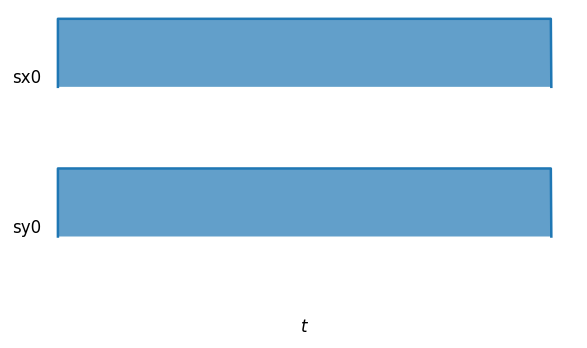

In [3]:
# Define a circuit and run the simulation
num_qubits = 1

circuit = QubitCircuit(1)
circuit.add_gate(Gate("RY", targets = 0, arg_value=2*np.pi))
#circuit.add_gate(Gate("RY", targets = 0, arg_value=1/4))
#circuit.add_gate("RX", targets=0, arg_value=np.pi)

myprocessor = simple_processor(num_qubits)
mycompiler = simple_compiler(num_qubits, {"pulse_amplitude": 0.1})

myprocessor.load_circuit(circuit, compiler=mycompiler)
result = myprocessor.run_state(basis(2, 0))

fig, ax = myprocessor.plot_pulses(figsize=(5, 3), dpi=120, use_control_latex=False)
ax[-1].set_xlabel("$t$")
fig.tight_layout()

fidelity(result.states[-1], result.states[0])

Testing to see the pulse duration

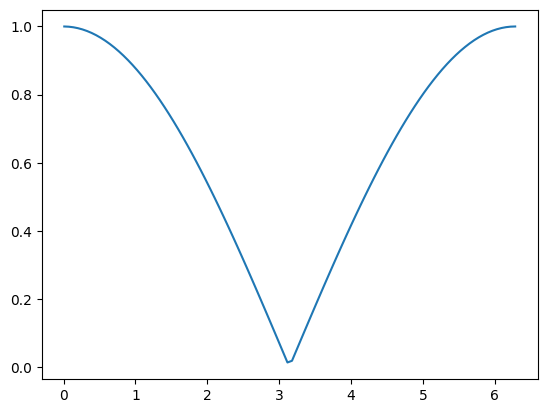

In [4]:
fidelity_list = []
index_list = []

for x in np.linspace(0.01,2*np.pi,100):
    circuit = QubitCircuit(1)
    circuit.add_gate("RX", targets=0, arg_value=x)
    #circuit.add_gate("RX", targets=0, arg_value=np.pi)

    myprocessor = simple_processor(num_qubits)
    myprocessor.native_gates = ["RX", "RY"]
    mycompiler = simple_compiler(num_qubits, {"pulse_amplitude": 1})

    myprocessor.load_circuit(circuit, compiler=mycompiler)
    result = myprocessor.run_state(basis(2, 0))
    fidelity_list.append(fidelity(result.states[-1], result.states[0]))
    index_list.append(x)

plt.plot(index_list,fidelity_list)

## Inverse gate search for RB

Check if any pulse sequence return a fidelity not $\approx 1$

In [8]:
def test_sim():
    num_gates = 3
    num_qubits = 1
    myprocessor = simple_processor(num_qubits)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 1})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = matrix_list[ind] * clifford

    # Finding inverse Clifford for the random sequence of gate
    add_inverse_gates(clifford,init_state,matrix_list,gates_set)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])
    return final_fidelity

In [9]:
i = 0
for x in range(100):
    final_fidelity = test_sim()
    if not np.round(final_fidelity,2) == 1:
        i = i + 1
print(i)

84


In [10]:
i = 0
for x in range(100):
    num_gates = 10
    num_qubits = 1
    myprocessor = simple_processor(num_qubits)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 1})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = matrix_list[ind] * clifford

    # Finding inverse Clifford for the random sequence of gate
    add_inverse_gates(clifford,init_state,matrix_list,gates_set)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])
    if not np.round(final_fidelity,2) == 1:
        i = i + 1
print(i)

0


## Gaussian noise

In [11]:
# Define a circuit and run the simulation
num_qubits = 1

circuit = QubitCircuit(num_qubits)
circuit.add_gate(Gate("RY", targets = 0, arg_value=np.pi))

myprocessor = simple_processor(num_qubits)
myprocessor.native_gates = None
mycompiler = simple_compiler(num_qubits, {"pulse_amplitude": 1})

myprocessor.load_circuit(circuit, compiler=mycompiler)
gaussnoise = RandomNoise(dt=0.01,indices = [0,1], rand_gen=np.random.normal, loc=0, scale=0.03)
myprocessor.add_noise(gaussnoise)

C:\Users\XPS13-9360\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qutip_qip\device\processor.py:844: UserWarning: No method get_control_latex defined in the model. Switch to using the labels defined in each pulse.Set use_control_latex=False to turn off the warning.
  warnings.warn(


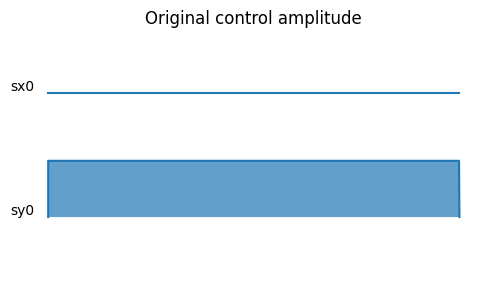

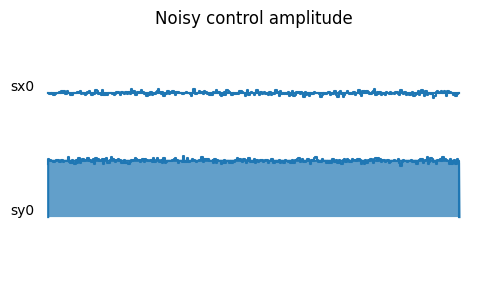

In [12]:
# Plot the ideal pulse
myprocessor.plot_pulses(title="Original control amplitude", figsize=(5,3), rescale_pulse_coeffs = False)

# Plot the noisy pulse
qobjevo, _ = myprocessor.get_qobjevo(noisy=True)
noisy_coeff0 = qobjevo.to_list()[1][1] + qobjevo.to_list()[2][1]
noisy_coeff1 = qobjevo.to_list()[3][1] + qobjevo.to_list()[4][1]
fig2, axis2 = myprocessor.plot_pulses(title="Noisy control amplitude", figsize=(5,3), rescale_pulse_coeffs = False)
axis2[0].step(qobjevo.tlist, noisy_coeff0)
axis2[1].step(qobjevo.tlist, noisy_coeff1)

## Randomized Benchmarking

### Without any noise

In [13]:
# For num_sample = 20, takes about 4 min
num_sample = 5
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,10)
fidelity_list = []
fidelity_average = []
fidelity_error = []

for num_gates in num_gates_list:
    for i in range(num_sample):
        num_qubits = 1
        myprocessor = simple_processor(num_qubits)
        myprocessor.native_gates = None  # Remove the native gates
        mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 1})

        # Ground state for n qubits
        init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

        # Define a random circuit.
        circuit = QubitCircuit(num_qubits)
        clifford = rx(0)
        for ind in np.random.randint(0, 6, num_gates):
            circuit.add_gate(gates_set[ind])
            clifford = matrix_list[ind] * clifford

        # Finding inverse Clifford for the random sequence of gate
        add_inverse_gates(clifford,init_state,matrix_list,gates_set)

        # Simulate the circuit.
        myprocessor.load_circuit(circuit, compiler=mycompiler)
        result = myprocessor.run_state(init_state, solver="mesolve")
        # Measured fidelity at the end
        final_fidelity = fidelity(result.states[0],result.states[-1])
        fidelity_list.append(final_fidelity)

    fidelity_average.append(np.mean(fidelity_list))
    fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    #print(num_gates)

Text(0, 0.5, 'Ground State Fidelity')

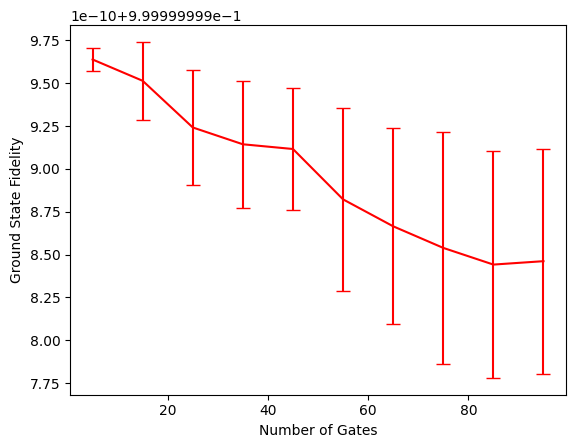

In [14]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_average, yerr=fidelity_error, color='red', capsize=5)
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

### With Gaussian noise

In [15]:
# For num_sample = 20, takes about 4 min
num_sample = 5
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,10)
fidelity_list = []
fidelity_average = []
fidelity_error = []

for num_gates in num_gates_list:
    for i in range(num_sample):
        num_qubits = 1
        myprocessor = simple_processor(num_qubits)
        myprocessor.native_gates = None  # Remove the native gates
        mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 1})

        # Ground state for n qubits
        init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

        # Define a random circuit.
        circuit = QubitCircuit(num_qubits)
        clifford = rx(0)
        for ind in np.random.randint(0, 6, num_gates):
            circuit.add_gate(gates_set[ind])
            clifford = matrix_list[ind] * clifford

        # Finding inverse Clifford for the random sequence of gate
        add_inverse_gates(clifford,init_state,matrix_list,gates_set)

        # Simulate the circuit.
        myprocessor.load_circuit(circuit, compiler=mycompiler)
        gaussnoise = RandomNoise(dt=0.01,indices = [0,1], rand_gen=np.random.normal, loc=0, scale=0.03)
        myprocessor.add_noise(gaussnoise)
        result = myprocessor.run_state(init_state, solver="mesolve")
        # Measured fidelity at the end
        final_fidelity = fidelity(result.states[0],result.states[-1])
        fidelity_list.append(final_fidelity)

    fidelity_average.append(np.mean(fidelity_list))
    fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    #print(num_gates)

Text(0, 0.5, 'Ground State Fidelity')

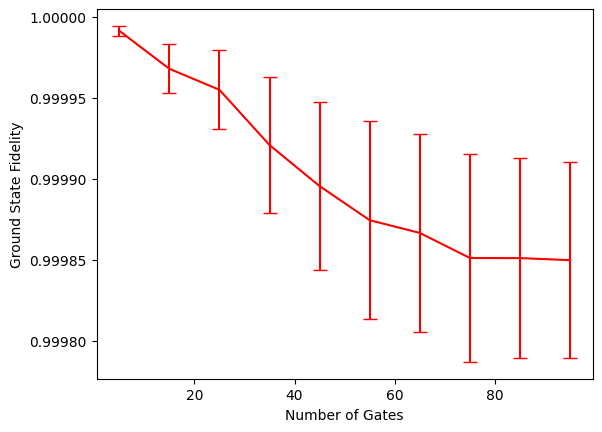

In [16]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_average, yerr=fidelity_error, color='red', capsize=5)
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

### With noise and decoherence

In [17]:
T1 = 0.01
T2 = 0.01

In [18]:
# For num_sample = 20, takes about 4 min
num_sample = 5
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,10)
fidelity_list = []
fidelity_average = []
fidelity_error = []

for num_gates in num_gates_list:
    for i in range(num_sample):
        num_qubits = 1
        myprocessor = simple_processor(num_qubits, t1 = T1, t2 = T2)
        myprocessor.native_gates = None  # Remove the native gates
        mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 1})

        # Ground state for n qubits
        init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

        # Define a random circuit.
        circuit = QubitCircuit(num_qubits)
        clifford = rx(0)
        for ind in np.random.randint(0, 6, num_gates):
            circuit.add_gate(gates_set[ind])
            clifford = matrix_list[ind] * clifford

        # Finding inverse Clifford for the random sequence of gate
        add_inverse_gates(clifford,init_state,matrix_list,gates_set)

        # Simulate the circuit.
        myprocessor.load_circuit(circuit, compiler=mycompiler)
        gaussnoise = RandomNoise(dt=0.01,indices = [0,1], rand_gen=np.random.normal, loc=0, scale=0.03)
        myprocessor.add_noise(gaussnoise)
        result = myprocessor.run_state(init_state, solver="mesolve")
        # Measured fidelity at the end
        final_fidelity = fidelity(result.states[0],result.states[-1])
        fidelity_list.append(final_fidelity)

    fidelity_average.append(np.mean(fidelity_list))
    fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    #print(num_gates)

Text(0, 0.5, 'Ground State Fidelity')

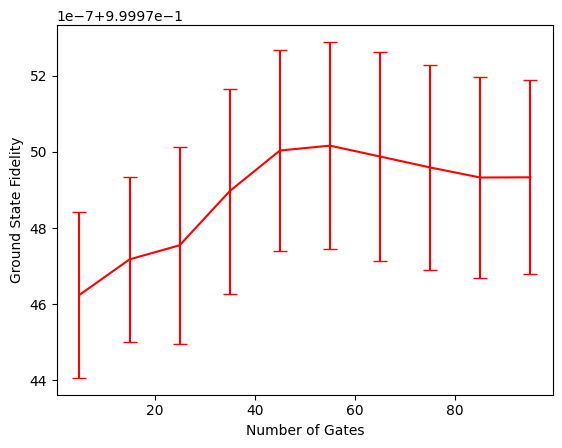

In [19]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_average, yerr=fidelity_error, color='red', capsize=5)
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")